<a href="https://colab.research.google.com/github/jacobdwatters/NIOSH-Project/blob/main/Violation_edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [34]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from joblib import dump, load

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [36]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [37]:
# Import Datasets and PreProcessing

# violations = pd.read_csv ("https://arlweb.msha.gov/OpenGovernmentData/DataSets/Violations.zip", encoding='latin-1', compression='zip', sep='|')

# violations['VIOLATOR_VIOLATION_CNT'] = violations['VIOLATOR_VIOLATION_CNT'].fillna('0')
# violations['PROPOSED_PENALTY'] = violations['PROPOSED_PENALTY'].fillna('0')
# violations['MINE_TYPE'] = violations['MINE_TYPE'].fillna('Facility')
# violations['LIKELIHOOD'] = violations['LIKELIHOOD'].fillna('NoLikelihood')
# violations['PROPOSED_PENALTY'] = violations['PROPOSED_PENALTY'].fillna('0')
# violations['NEGLIGENCE'] = violations['NEGLIGENCE'].fillna('NONEGLIGENCE')
# violations['NEGLIGENCE'] = violations['VIOLATION_ISSUE_TIME'].fillna('2319')
# violations['COAL_METAL_IND'] = violations['COAL_METAL_IND'].fillna('M')
# violations['NO_AFFECTED'] = violations['NO_AFFECTED'].fillna('0')
# violations['INJ_ILLNESS'] = violations['INJ_ILLNESS'].fillna('NoLostDays')
# violations['SIG_SUB'] = violations['SIG_SUB'].fillna('N')

# violations['VIOLATION_OCCUR_DT'] = pd.to_datetime(violations['VIOLATION_OCCUR_DT'], format='%m/%d/%Y', exact=False)
# violations.reset_index(inplace=True)
# violations['day_occur'] = violations['VIOLATION_OCCUR_DT'].dt.day
# violations['month_occur'] = violations['VIOLATION_OCCUR_DT'].dt.month
# violations['year_occur'] = violations['VIOLATION_OCCUR_DT'].dt.year

# violations['year_occur'] = violations['year_occur'].fillna('1999')

# violations = violations._convert(numeric=True)

violations = pd.read_csv('gdrive/My Drive/NIOSH Project/data/violations_processed.csv')

# Selecting Parameters
X = violations[['year_occur', 
          'VIOLATION_ISSUE_TIME',
          'VIOLATOR_VIOLATION_CNT',
          'MINE_TYPE', 
          'COAL_METAL_IND', 
          'NEGLIGENCE',
          'LIKELIHOOD', 
          'NO_AFFECTED',
          'INJ_ILLNESS',
          'SIG_SUB']]

y = violations['PROPOSED_PENALTY']

# processed_data = pd.concat([X, y], axis=1)
# path = '/content/gdrive/My Drive/NIOSH Project/data/violations_processed.csv'
# with open(path, 'w', encoding='utf-8') as f:
#   processed_data.to_csv(f)

# del(processed_data)
del(violations)

In [38]:
X.isnull().sum()

year_occur                0
VIOLATION_ISSUE_TIME      1
VIOLATOR_VIOLATION_CNT    0
MINE_TYPE                 0
COAL_METAL_IND            0
NEGLIGENCE                0
LIKELIHOOD                0
NO_AFFECTED               0
INJ_ILLNESS               0
SIG_SUB                   0
dtype: int64

In [39]:
X.SIG_SUB.value_counts(dropna=False)

N    1998484
Y     755523
Name: SIG_SUB, dtype: int64

In [40]:
X.dtypes

year_occur                float64
VIOLATION_ISSUE_TIME      float64
VIOLATOR_VIOLATION_CNT    float64
MINE_TYPE                  object
COAL_METAL_IND             object
NEGLIGENCE                float64
LIKELIHOOD                 object
NO_AFFECTED               float64
INJ_ILLNESS                object
SIG_SUB                    object
dtype: object

In [41]:
# Define which columns should be encoded vs scaled
columns_to_encode = ['MINE_TYPE','COAL_METAL_IND','LIKELIHOOD','INJ_ILLNESS','SIG_SUB']
columns_to_scale  = ['year_occur', 'VIOLATION_ISSUE_TIME', 'NEGLIGENCE', 'VIOLATOR_VIOLATION_CNT','NO_AFFECTED']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns  = scaler.fit_transform(X[columns_to_scale])
encoded_columns = ohe.fit_transform(X[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
X_pre = np.concatenate([scaled_columns, encoded_columns], axis=1)
np.nan_to_num(X_pre, copy=False)

print("Features shape:", X_pre.shape)


# Bin the values into 5 equally sized bins.
y_bins = pd.cut(y, 5)

le = LabelEncoder()
y_pre = le.fit_transform(y_bins)

n = len(pd.unique(y))
print("No.of.unique values in y:", n)

Features shape: (2754007, 21)
No.of.unique values in y: 1957


In [42]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_pre, y_pre, test_size = 0.25, random_state = 0)

In [43]:
# Fitting classifier to the Training set
set_config(display='diagram')

model = LogisticRegression(max_iter=300000)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Accuracy of logistic regression: {accuracy:.3f}")

# Save the model
dump(model, 'gdrive/My Drive/NIOSH Project/violation_logreg_trained.joblib') 

Accuracy of logistic regression: 0.999


['gdrive/My Drive/NIOSH Project/violation_logreg_trained.joblib']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


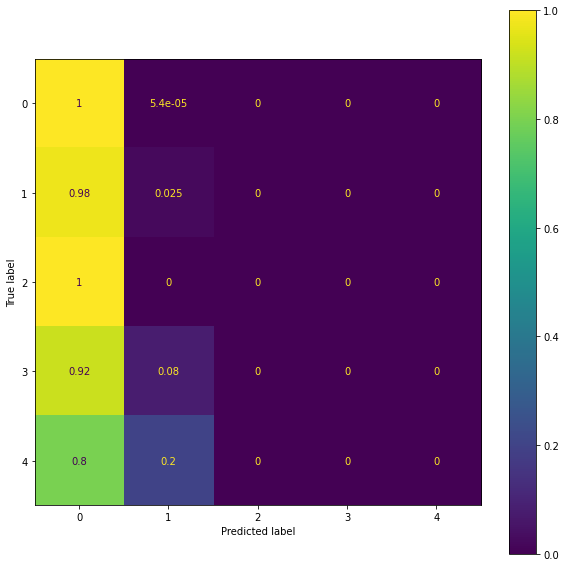

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model, X_test, y_test, ax=ax, normalize='true')
plt.title('Normalized Confusion Matrix')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Confusion Matrix')

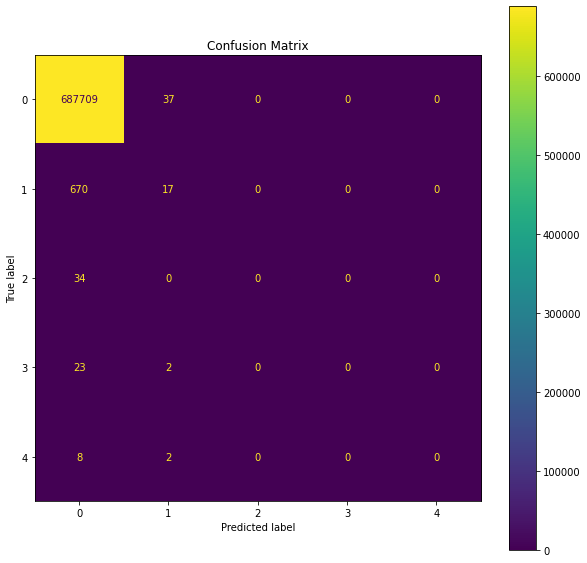

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model, X_test, y_test, ax=ax)
plt.title('Confusion Matrix')